In [1]:
%matplotlib inline



# Naima spectral model

This class provides an interface with the models defined in the naima models module.

The model accepts as a positional argument a [Naima](https://naima.readthedocs.io/en/latest/)
radiative `~naima.models` instance, used to compute the non-thermal emission from populations of
relativistic electrons or protons due to interactions with the ISM or with radiation and magnetic fields.

One of the advantages provided by this class consists in the possibility of performing a maximum
likelihood spectral fit of the model's parameters directly on observations, as opposed to the MCMC
[fit to flux points](https://naima.readthedocs.io/en/latest/mcmc.html) featured in
Naima. All the parameters defining the parent population of charged particles are stored as
`~gammapy.modeling.Parameter` and left free by default. In case that the radiative model is
`~naima.radiative.Synchrotron`, the magnetic field strength may also be fitted. Parameters can be
freezed/unfreezed before the fit, and maximum/minimum values can be set to limit the parameters space to
the physically interesting region.


## Example plot
Here we create and plot a spectral model that convolves an `~gammapy.modeling.models.ExpCutoffPowerLawSpectralModel`
electron distribution with an `InverseCompton` radiative model, in the presence of multiple seed photon fields.



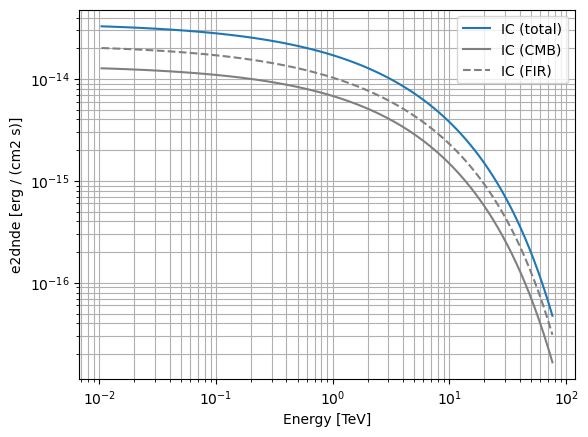

In [2]:
from astropy import units as u
import matplotlib.pyplot as plt
import naima
from gammapy.modeling.models import Models, NaimaSpectralModel, SkyModel
import numpy as np
particle_distribution = naima.models.ExponentialCutoffPowerLaw(
    1e30 / u.eV, 10 * u.TeV, 3.0, 30 * u.TeV
)
radiative_model = naima.radiative.InverseCompton(
    particle_distribution,
    seed_photon_fields=["CMB", ["FIR", 26.5 * u.K, 0.415 * u.eV / u.cm**3]],
    Eemin=100 * u.GeV,
)

model = NaimaSpectralModel(radiative_model, distance=3.606 * u.kpc)

opts = {
    "energy_bounds": [10 * u.GeV, 80 * u.TeV],
    "sed_type": "e2dnde",
}

# Plot the total inverse Compton emission
model.plot(label="IC (total)", **opts)

# Plot the separate contributions from each seed photon field
for seed, ls in zip(["CMB", "FIR"], ["-", "--"]):
    model = NaimaSpectralModel(radiative_model, seed=seed, distance=3.606 * u.kpc)
    model.plot(label=f"IC ({seed})", ls=ls, color="gray", **opts)

plt.legend(loc="best")
plt.grid(which="both")

In [4]:
print(model)

NaimaSpectralModel

  type      name     value    unit   error   min max frozen is_norm link
-------- --------- ---------- ---- --------- --- --- ------ ------- ----
spectral amplitude 1.0000e+30 eV-1 0.000e+00 nan nan  False    True     
spectral       e_0 1.0000e+01  TeV 0.000e+00 nan nan  False   False     
spectral     alpha 3.0000e+00      0.000e+00 nan nan  False   False     
spectral  e_cutoff 3.0000e+01  TeV 0.000e+00 nan nan  False   False     
spectral      beta 1.0000e+00      0.000e+00 nan nan  False   False     


## YAML representation
Here is an example YAML file using the model:



In [25]:
model = SkyModel(spectral_model=model, name="naima-model")
models = Models([model])

print(models.to_yaml())

components:
-   name: naima-model
    type: SkyModel
    spectral:
        type: NaimaSpectralModel
        parameters:
        -   name: amplitude
            value: 1.0e+30
            unit: eV-1
            error: 0
            min: .nan
            max: .nan
            frozen: false
            interp: lin
            scale_method: scale10
            is_norm: true
        -   name: e_0
            value: 10.0
            unit: TeV
            error: 0
            min: .nan
            max: .nan
            frozen: false
            interp: lin
            scale_method: scale10
            is_norm: false
        -   name: alpha
            value: 3.0
            unit: ''
            error: 0
            min: .nan
            max: .nan
            frozen: false
            interp: lin
            scale_method: scale10
            is_norm: false
        -   name: e_cutoff
            value: 30.0
            unit: TeV
            error: 0
            min: .nan
            max: .nan
 

### Radiative Models

In [26]:
ECPL = naima.models.ExponentialCutoffPowerLaw(
    1e36 * u.Unit("1/eV"), 1 * u.TeV, 2.1, 13 * u.TeV
)
# IC = naima.models.InverseCompton(ECPL, seed_photon_fields=["CMB"])
IC = naima.models.InverseCompton(ECPL, seed_photon_fields=['CMB', 'FIR', 'NIR'])


In [27]:
IC.particle_distribution.index = 1.8
print(ECPL.index)

1.8


In [28]:
SYN = naima.models.Synchrotron(ECPL, B=100 * u.uG)
SYN.particle_distribution is IC.particle_distribution

True

In [29]:
spectrum_energy = np.logspace(-1, 15, 1000) * u.eV
sed_IC = IC.sed(spectrum_energy, distance=3.606 * u.kpc)
sed_SYN = SYN.sed(spectrum_energy, distance=3.606 * u.kpc)

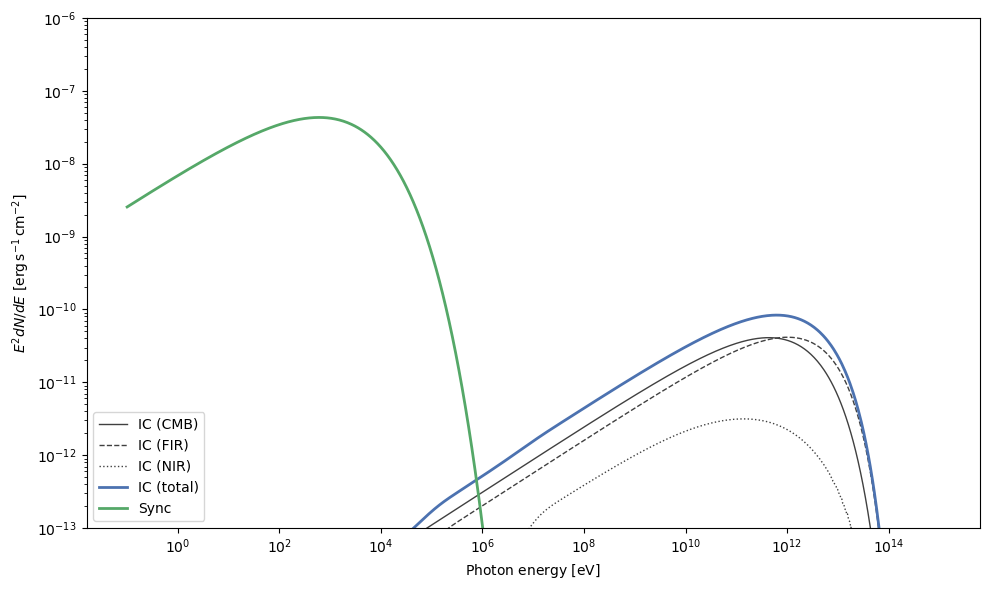

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
# ax.xaxis.set_units(u.Unit("TeV"))

plt.rc('font', family='sans')
plt.rc('mathtext', fontset='custom')
for seed, ls in zip(['CMB', 'FIR', 'NIR'], ['-','--',':']):
    sed = IC.sed(spectrum_energy, seed=seed, distance=3.606*u.kpc)
    plt.loglog(spectrum_energy,sed,lw=1,
            ls=ls,label='IC ({0})'.format(seed),c='0.25')
plt.loglog(spectrum_energy,sed_IC,lw=2,
        label='IC (total)',c=naima.plot.color_cycle[0])
plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync',c=naima.plot.color_cycle[1])
plt.xlabel('Photon energy [{0}]'.format(
        spectrum_energy.unit.to_string('latex_inline')))
plt.ylabel('$E^2 dN/dE$ [{0}]'.format(
        sed_SYN.unit.to_string('latex_inline')))
plt.ylim(1e-13, 1e-6)
plt.tight_layout()
plt.legend(loc='lower left')


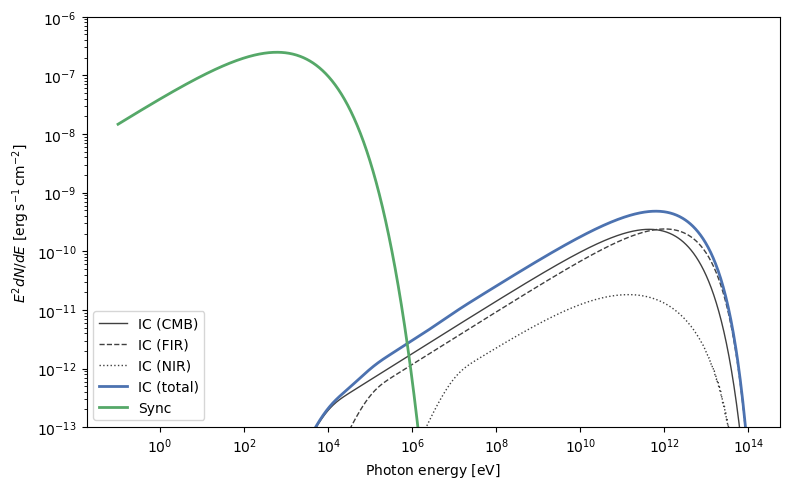

In [15]:
import naima
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

# Define models
ECPL = naima.models.ExponentialCutoffPowerLaw(1e36*u.Unit('1/eV'),
        1*u.TeV, 2.1, 13*u.TeV)

IC = naima.models.InverseCompton(ECPL, seed_photon_fields=['CMB', 'FIR', 'NIR'])
IC.particle_distribution.index = 1.8
SYN = naima.models.Synchrotron(ECPL, B=100*u.uG)

# Compute SEDs
spectrum_energy = np.logspace(-1,14,1000)*u.eV
sed_IC = IC.sed(spectrum_energy, distance=1.5*u.kpc)
sed_SYN = SYN.sed(spectrum_energy, distance=1.5*u.kpc)

# Plot
plt.figure(figsize=(8,5))
plt.rc('font', family='sans')
plt.rc('mathtext', fontset='custom')
for seed, ls in zip(['CMB', 'FIR', 'NIR'], ['-','--',':']):
    sed = IC.sed(spectrum_energy, seed=seed, distance=1.5*u.kpc)
    plt.loglog(spectrum_energy,sed,lw=1,
            ls=ls,label='IC ({0})'.format(seed),c='0.25')
plt.loglog(spectrum_energy,sed_IC,lw=2,
        label='IC (total)',c=naima.plot.color_cycle[0])
plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync',c=naima.plot.color_cycle[1])
plt.xlabel('Photon energy [{0}]'.format(
        spectrum_energy.unit.to_string('latex_inline')))
plt.ylabel('$E^2 dN/dE$ [{0}]'.format(
        sed_SYN.unit.to_string('latex_inline')))
plt.ylim(1e-13, 1e-6)
plt.tight_layout()
plt.legend(loc='lower left')